In [71]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [72]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

df = pd.read_csv('./predict-student-performance-from-game-play/train.csv', dtype=dtypes)
print("Full train dataset shape is {}".format(df.shape))

Full train dataset shape is (26296946, 20)


In [73]:
# Display the first 5 examples
df.head(5)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [74]:
#Loading the training labels which states whether a person answered the question correctly in a session
labels = pd.read_csv('./predict-student-performance-from-game-play/train_labels.csv')

In [75]:
#Each session id consists of both session number and the question number which are separated by a '-'
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

'There are more right values than there are wrong ones'

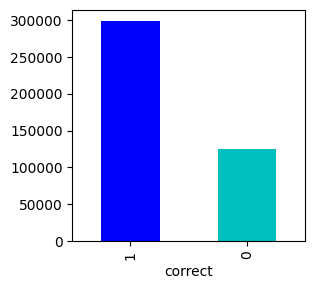

In [76]:
plt.figure(figsize=(3, 3))
plot_df = labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

'''There are more right values than there are wrong ones'''

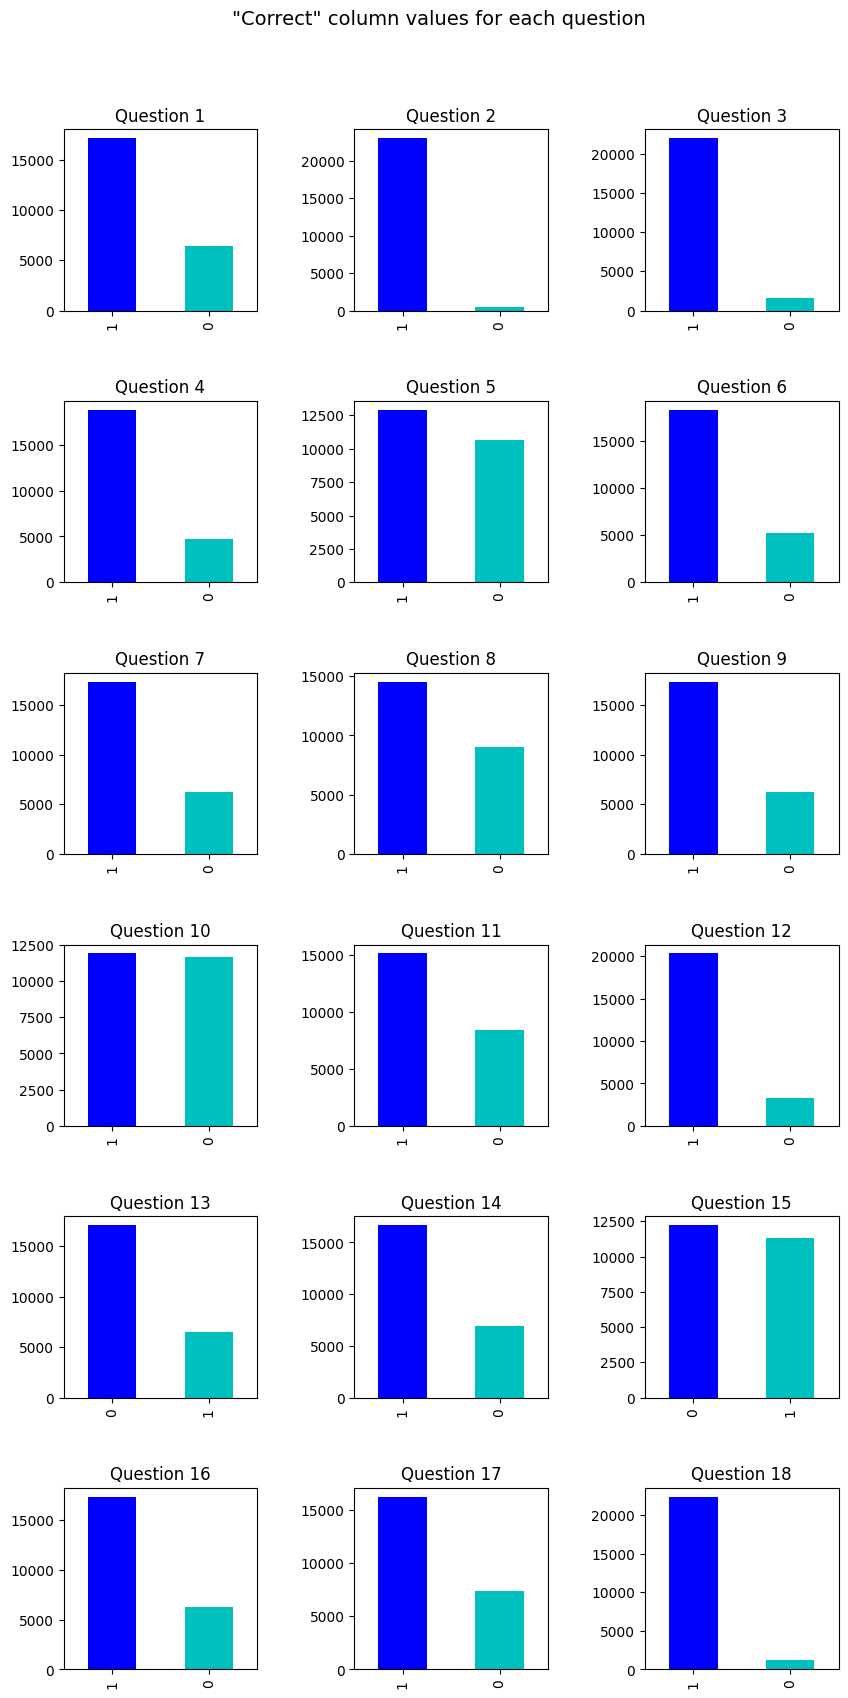

In [77]:
#  We are plotting the correct percentage of each question

plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for each question", fontsize=14, y=0.94)
for n in range(1,19):
    #print(n, str(n))
    ax = plt.subplot(6, 3, n)

    # filter df and plot ticker on the new subplot axis
    plot_df = labels.loc[labels.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['b', 'c'])
    
    # chart formatting
    ax.set_title("Question " + str(n))
    ax.set_xlabel("")


#### As we observe from the charts above, Qn 5, 10 and 15 are the worst performing questions in this set

In [78]:
# split the categorical columns to the numerical ones 

CAT = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUM = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']


In [79]:
def feature_engineering(df):
    dfs =[]
    for c in CAT:
        temp = df.groupby(['session_id','level_group'])[c].agg('nunique')
        temp.name = temp.name+'_nunique'
        dfs.append(temp)
    for c in NUM:
        temp = df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(temp)
    for c in NUM:
        temp = df.groupby(['session_id','level_group'])[c].agg('std')
        temp.name = temp.name + '_std'
        dfs.append(temp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [80]:
df = feature_engineering(df)
# used for actual prediction
data = df.copy()
data['new_feature'] = 0
df = df.reset_index()
df['correct'] = 0
print(f'Shape of prepared dataset: {df.shape}')

Shape of prepared dataset: (70686, 24)


In [81]:
df.head(5)

,session_id,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,...,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,correct
0,20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,...,2389.500000,49246.539458,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757,0
1,20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,...,899.925903,126666.129584,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265,0
2,20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,...,969.333313,80175.676658,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315,0
3,20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,...,1378.750000,67372.714092,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406,0
4,20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,...,720.384949,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518,0


In [82]:
labels.head(5)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


# Data Engineering

In [83]:
# Function checks if the key exists in the dictionary
def check_key(key, dict):
    if key in dict:
        return True
    else:
        return False
    
 # Function updates the 'correct' and 'count' values in the dictionary with corresponding key
def update_correct(key, val, dict):
   dict[key]['correct'] += val
   dict[key]['count'] += 1
   return dict

In [84]:
# Function: For each session, it compresses all data within level_group with the same key and stores it in a dictionary where the key is the session_id 
# and the value is a dictionary with number of correct and how many observations of key is in the dictionary.
# Example: bin1: {20090312431273200: {'correct':4, 'count':5, 'q':2}} -> dataframe['correct'] = 4/5
# Example: bin2: {20090312431273200: {'correct':3, 'count':3, 'q':6}} -> dataframe['correct'] = 3/3

def compress_label(labels):
    bin1 = {}
    bin2 = {}
    bin3 = {}

    for i in range(0, len(labels)):
        # checks bin1 if q <= 4
        if labels['q'].loc[i] <= 4:
            # if the session, a key, exists in bin1 we update the key-value
            if check_key(labels['session'].loc[i], bin1) == True:
                update_correct(labels['session'].loc[i], labels['correct'].loc[i], bin1)
            # if it doesn't exist, we create a new key-value pair in bin1
            else:
                bin1[labels['session'].loc[i]] = {'correct':labels['correct'].loc[i], 'count':1}

        # checks bin2 if 5<= q <= 12
        elif 5<= labels['q'].loc[i] <= 12:
            # if the session, a key, exists in bin2 we update the key-value
            if check_key(labels['session'].loc[i], bin2) == True:
                update_correct(labels['session'].loc[i], labels['correct'].loc[i], bin2)
            # if it doesn't exist, we create a new key-value pair in bin2
            else:
                bin2[labels['session'].loc[i]] = {'correct':labels['correct'].loc[i], 'count':1}
        
        # checks bin3 if q >= 13
        else:
            # if the session, a key, exists in bin3 we update the key-value
            if check_key(labels['session'].loc[i], bin3) == True:
                update_correct(labels['session'].loc[i], labels['correct'].loc[i], bin3)
            # if it doesn't exist, we create a new key-value pair in bin1
            else:
                bin3[labels['session'].loc[i]] = {'correct':labels['correct'].loc[i], 'count':1}
    return bin1, bin2, bin3

In [85]:
# Function merges values in each of the three bins with the data frame accordingly
def merge_labels(b1, b2, b3, dataframe):
    # for every observation in data frame, we store the session_id as key
    for i in range(0, len(dataframe)):
        key = dataframe['session_id'].loc[i]
        # if the level group is 0-4, we store correct/count in the correct column of the data frame from bin1
        if dataframe['level_group'].loc[i] == '0-4':
            dataframe['correct'].loc[i] = b1[key]['correct']/b1[key]['count']
        # if the level group is 5-12... bin2
        elif dataframe['level_group'].loc[i] == '5-12':
            dataframe['correct'].loc[i] = b2[key]['correct']/b2[key]['count']
        # else... bin3
        else:
            dataframe['correct'].loc[i] = b3[key]['correct']/b3[key]['count']
    return dataframe

In [86]:
bin1, bin2, bin3 = compress_label(labels)
merge_labels(bin1, bin2, bin3, df)

/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/1862425998.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['correct'].loc[i] = b1[key]['correct']/b1[key]['count']
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/1862425998.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['correct'].loc[i] = b3[key]['correct']/b3[key]['count']


,session_id,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,...,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,correct
0,20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.000000,...,2389.500000,4.924654e+04,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757,1.000000
1,20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.000000,...,899.925903,1.266661e+05,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265,0.666667
2,20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.000000,...,969.333313,8.017568e+04,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315,1.000000
3,20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.000000,...,1378.750000,6.737271e+04,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406,0.750000
4,20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.100000,...,720.384949,7.773825e+05,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70681,22100219442786200,13-22,11,4,49,12,33,9.619192e+05,17.671395,5.230769,...,1110.500000,1.516019e+05,2.359474,0.908083,589.562720,273.090325,248.584999,134.772721,1675.299532,0.666667
70682,22100219442786200,5-12,11,6,41,11,20,3.866058e+05,8.111511,1.833333,...,1328.250000,9.665042e+04,2.180934,0.923548,390.345335,147.579436,250.827193,135.693654,1910.823123,0.750000
70683,22100221145014656,0-4,11,4,27,7,17,2.036104e+05,2.061611,0.333333,...,4164.636230,1.085422e+05,1.276526,0.516398,392.539487,159.619091,213.638122,128.499750,6725.520698,0.500000
70684,22100221145014656,13-22,11,4,54,13,36,4.899580e+06,18.127632,5.181818,...,669.000000,3.370855e+05,2.210473,0.906924,566.855306,249.156178,232.192779,122.521568,1115.700943,0.333333


In [87]:
y = df['correct']
x = df.drop(columns=['correct', 'level_group', 'session_id'])
select = SelectKBest(f_classif, k = 3).fit(x,y)

x = select.transform(x)

In [88]:
x

array([[  1.94545455, 399.29603826, 129.29241094],
       [ 17.40238095, 622.06137436, 230.37087354],
       [  8.05405405, 357.22770128, 137.40947558],
       ...,
       [  2.06161137, 392.5394866 , 159.6190909 ],
       [ 18.12763158, 566.85530572, 249.15617843],
       [  8.33854167, 344.40625593, 133.72849994]])

In [89]:
regressor = svm.SVR()
regressor.fit(x,y)

SVR()

In [90]:
data['new_feature'] = regressor.predict(x)
data.head(5)

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,new_feature
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,2389.500000,49246.539458,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757,0.902904
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347168,...,899.925903,126666.129584,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265,0.640357
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,969.333313,80175.676658,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315,0.724840
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045959,...,1378.750000,67372.714092,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406,0.898030
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762283,...,720.384949,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518,0.563114


# PCA

In [91]:
FEATURE = [c for c in data.columns if c != 'level_group']
print('We will train with', len(FEATURE) ,'features')
ALL_USER = data.index.unique()
print('We will train with', len(ALL_USER) ,'users info')

We will train with 22 features
We will train with 23562 users info


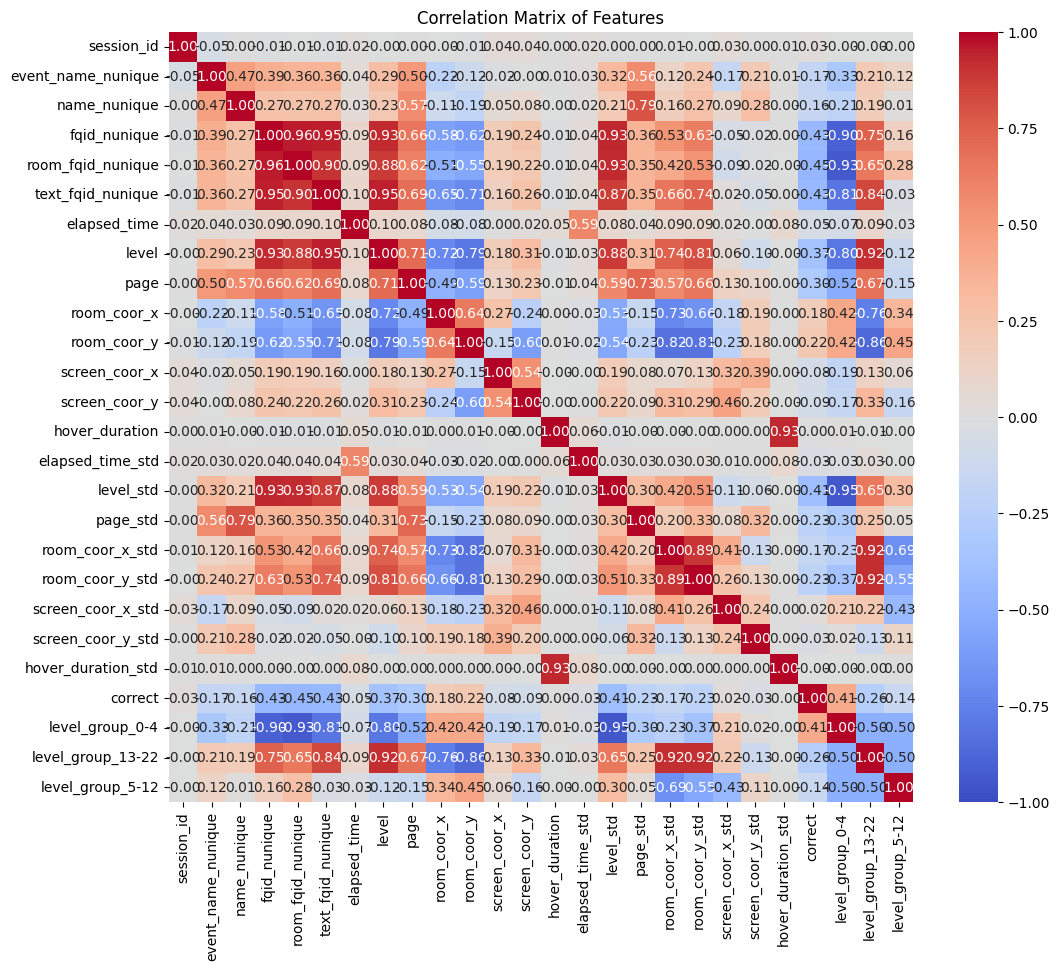

Explained Variance Ratio: [0.40532662 0.18586438 0.1310772  0.11730836]


In [92]:
df_encoded = data.copy()
# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['level_group'])

# Standardize numerical features
scaler = StandardScaler()
df_encoded[NUM] = scaler.fit_transform(df_encoded[NUM])

# Compute the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()

# Perform PCA
pca = PCA(n_components=4)  # Set the number of components you want
principal_components = pca.fit_transform(df_encoded[NUM])

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Print the explained variance ratio
print('Explained Variance Ratio:', pca.explained_variance_ratio_)

In [93]:
New_NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration','event_name_nunique',
            'name_nunique','fqid_nunique', 'room_fqid_nunique', 'text_fqid_nunique','elapsed_time_std', 'level_std', 'page_std', 'room_coor_x_std',
       'room_coor_y_std', 'screen_coor_x_std', 'screen_coor_y_std',
       'hover_duration_std']
# Reset the index of both DataFrames
df_encoded_reset = df_encoded.drop(New_NUMS, axis=1).reset_index(drop=False)
df_pca_reset = df_pca.reset_index(drop=True)

# Merge the PCA results with the one-hot encoded categorical features
df_final = pd.concat([df_encoded_reset, df_pca_reset], axis=1)
display(df_final.head())
df_final.set_index('session_id', inplace=True)

,index,session_id,correct,level_group_0-4,level_group_13-22,level_group_5-12,PC1,PC2,PC3,PC4
0,0,20090312431273200,1.000000,True,False,False,-1.377241,0.392131,-0.029253,0.027141
1,1,20090312431273200,0.666667,False,True,False,1.157863,-0.680041,-0.176513,0.174903
2,2,20090312431273200,1.000000,False,False,True,-1.068281,0.312236,-0.032959,0.003455
3,3,20090312433251036,0.750000,True,False,False,-1.222271,-1.799677,-0.168841,0.162598
4,4,20090312433251036,0.500000,False,True,False,1.772592,-0.017075,-0.079840,0.042536


In [94]:
df_final['new_feature'] = data['new_feature']
df_final['level_group'] = data['level_group']
df_final = df_final.drop(columns=['level_group_0-4','level_group_5-12','level_group_13-22','correct','index'])
df_final.head(5)

,PC1,PC2,PC3,PC4,new_feature,level_group
session_id,,,,,,
20090312431273200,-1.377241,0.392131,-0.029253,0.027141,0.902904,0-4
20090312431273200,1.157863,-0.680041,-0.176513,0.174903,0.640357,13-22
20090312431273200,-1.068281,0.312236,-0.032959,0.003455,0.724840,5-12
20090312433251036,-1.222271,-1.799677,-0.168841,0.162598,0.898030,0-4
20090312433251036,1.772592,-0.017075,-0.079840,0.042536,0.563114,13-22


# Splitting Dataset

In [95]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = df_final.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, test_x = split_dataset(df_final)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(test_x)))

56547 examples in training, 14139 examples in testing.


In [96]:
train_x.head(5)

,PC1,PC2,PC3,PC4,new_feature,level_group
session_id,,,,,,
20090312431273200,-1.377241,0.392131,-0.029253,0.027141,0.902904,0-4
20090312431273200,1.157863,-0.680041,-0.176513,0.174903,0.640357,13-22
20090312431273200,-1.068281,0.312236,-0.032959,0.003455,0.724840,5-12
20090312433251036,-1.222271,-1.799677,-0.168841,0.162598,0.898030,0-4
20090312433251036,1.772592,-0.017075,-0.079840,0.042536,0.563114,13-22


In [97]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

To get started, we'll work with a Gradient Boosted Trees Model. This is one of the well-known Decision Forest training algorithms.

A Gradient Boosted Decision Tree is a set of shallow decision trees trained sequentially. Each tree is trained to predict and then "correct" for the errors of the previously trained trees.

# How can I configure a tree-based model?

TensorFlow Decision Forests provides good defaults for you (e.g., the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:
```
rf = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
```

You can read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel).

# Training


We will train a model for each question to predict if the question will be answered correctly by a user. 
There are a total of 18 questions in the dataset. Hence, we will be training 18 models, one for each question.

We need to provide a few data structures to our training loop to store the trained models, predictions on the validation set and evaluation scores for the trained models.

We will create these using the following code:


In [98]:
# Fetch the unique list of user sessions in the validation dataset. We assigned 
# `session_id` as the index of our feature engineered dataset. Hence fetching 
# the unique values in the index column will give us a list of users in the 
# validation set.
VALID_USER_LIST = test_x.index.unique()

# Create a dataframe for storing the predictions of each question for all users
# in the validation set.
# For this, the required size of the data frame is: 
# (no: of users in validation set  x no of questions).
# We will initialize all the predicted values in the data frame to zero.
# The dataframe's index column is the user `session_id`s. 
prediction_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

# Create an empty dictionary to store the models created for each question.
models = {}

# Create an empty dictionary to store the evaluation score for each question.
evaluation_dict ={}

In [99]:
prediction_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
22000320020067784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22000321083750010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22000401381351532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22000407142860316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22000407572357990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22100215460321130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22100217104993650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# Iterate through questions 1 to 18 to train models for each question, evaluate
# the trained model and store the predicted values.
for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)
    
        
    # Filter the rows in the datasets based on the selected level group. 
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = test_x.loc[test_x.level_group == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]

    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    # There's one more step required before we can train the model. 
    # We need to convert the datatset from Pandas format (pd.DataFrame)
    # into TensorFlow Datasets format (tf.data.Dataset).
    # TensorFlow Datasets is a high performance data loading library 
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    # We are omitting `level_group`, since it is not needed for training anymore.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")

    # We will now create the Gradient Boosted Trees Model with default settings. 
    # By default the model is set to train for a classification task.
    gbtm = tfdf.keras.RandomForestModel(verbose=0)
    gbtm.compile(metrics=["accuracy"])

    # Train the model.
    gbtm.fit(x=train_ds)

    # Store the model
    models[f'{grp}_{q_no}'] = gbtm

    # Evaluate the trained model on the validation dataset and store the 
    # evaluation accuracy in the `evaluation_dict`.
    inspector = gbtm.make_inspector()
    inspector.evaluation()
    evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)
    evaluation_dict[q_no] = evaluation["accuracy"]         

    # Use the trained model to make predictions on the validation dataset and 
    # store the predicted values in the `prediction_df` dataframe.
    predict = gbtm.predict(x=valid_ds)
    prediction_df.loc[valid_users, q_no-1] = predict.flatten()     

### q_no 1 grp 0-4


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:44:52.0964 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpzg3qc23o/model/ with prefix a3e889b77

5/5 [==============================] - 0s 29ms/step
### q_no 2 grp 0-4


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:44:54.4596 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpwvlklo8y/model/ with prefix 9bc5bb509

5/5 [==============================] - 0s 24ms/step
### q_no 3 grp 0-4


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:44:56.6971 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpantvysen/model/ with prefix d8821ab86

1/5 [=====>........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.9280

[INFO 23-05-10 14:44:56.9958 EDT decision_forest.cc:660] Model loaded with 300 root(s), 229314 node(s), and 5 input feature(s).
[INFO 23-05-10 14:44:56.9958 EDT kernel.cc:1074] Use fast generic engine


5/5 [==============================] - 0s 27ms/step
### q_no 4 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:44:59.4631 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmp7297hspl/model/ with prefix 0823321e0

5/5 [==============================] - 0s 29ms/step
### q_no 5 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:02.5842 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpqelvsqcg/model/ with prefix c54e2b1a1

5/5 [==============================] - 0s 30ms/step
### q_no 6 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:05.7183 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpnom0h553/model/ with prefix 56256f231

5/5 [==============================] - 0s 29ms/step
### q_no 7 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:08.7603 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmp8wp8_1cg/model/ with prefix f89627115

5/5 [==============================] - 0s 29ms/step
### q_no 8 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:11.5378 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpejhgrh84/model/ with prefix af8eadcd0

1/5 [=====>........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.6440

[INFO 23-05-10 14:45:11.9390 EDT decision_forest.cc:660] Model loaded with 300 root(s), 306122 node(s), and 5 input feature(s).
[INFO 23-05-10 14:45:11.9391 EDT kernel.cc:1074] Use fast generic engine


5/5 [==============================] - 0s 28ms/step
### q_no 9 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:14.2678 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpyq2w3lc9/model/ with prefix fcbc47ac0

1/5 [=====>........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7460

[INFO 23-05-10 14:45:14.7133 EDT decision_forest.cc:660] Model loaded with 300 root(s), 339878 node(s), and 5 input feature(s).
[INFO 23-05-10 14:45:14.7134 EDT abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-05-10 14:45:14.7134 EDT kernel.cc:1074] Use fast generic engine


5/5 [==============================] - 0s 28ms/step
### q_no 10 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:17.1433 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpj2x4_xsr/model/ with prefix 5a1013b71

5/5 [==============================] - 0s 28ms/step
### q_no 11 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:20.0043 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpsyt9o_yt/model/ with prefix e773d6807

5/5 [==============================] - 0s 30ms/step
### q_no 12 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:22.8047 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpoatnwdnb/model/ with prefix e2d76c3a0

1/5 [=====>........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.8580

[INFO 23-05-10 14:45:23.2162 EDT decision_forest.cc:660] Model loaded with 300 root(s), 313708 node(s), and 5 input feature(s).
[INFO 23-05-10 14:45:23.2163 EDT kernel.cc:1074] Use fast generic engine


5/5 [==============================] - 0s 28ms/step
### q_no 13 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:25.6150 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmplj_tqjes/model/ with prefix b35a42476

5/5 [==============================] - 0s 31ms/step
### q_no 14 grp 13-22


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:28.5170 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpuekazlgs/model/ with prefix f481d830e

5/5 [==============================] - 0s 30ms/step
### q_no 15 grp 13-22


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:31.6422 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmp2dfhuuy4/model/ with prefix 1ae5547d5

5/5 [==============================] - 0s 30ms/step
### q_no 16 grp 13-22


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:34.4086 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpq69go8rq/model/ with prefix 25d4735e3

1/5 [=====>........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7530

[INFO 23-05-10 14:45:34.7358 EDT decision_forest.cc:660] Model loaded with 300 root(s), 247608 node(s), and 5 input feature(s).
[INFO 23-05-10 14:45:34.7358 EDT kernel.cc:1074] Use fast generic engine


5/5 [==============================] - 0s 27ms/step
### q_no 17 grp 13-22


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:37.2269 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpfp5fuhey/model/ with prefix 1a0a0e7cb

5/5 [==============================] - 0s 30ms/step
### q_no 18 grp 13-22


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_37354/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-10 14:45:39.9292 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmp_ps_utmi/model/ with prefix 4da0e41c0

1/5 [=====>........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.9520

[INFO 23-05-10 14:45:40.2204 EDT decision_forest.cc:660] Model loaded with 300 root(s), 220990 node(s), and 5 input feature(s).
[INFO 23-05-10 14:45:40.2204 EDT kernel.cc:1074] Use fast generic engine


5/5 [==============================] - 0s 26ms/step


In [101]:
for name, value in evaluation_dict.items():
  print(f"question {name}: accuracy {value:.4f}")

print("\nAverage accuracy", sum(evaluation_dict.values())/18)

question 1: accuracy 0.7295
question 2: accuracy 0.9756
question 3: accuracy 0.9349
question 4: accuracy 0.7902
question 5: accuracy 0.5854
question 6: accuracy 0.7857
question 7: accuracy 0.7443
question 8: accuracy 0.6336
question 9: accuracy 0.7596
question 10: accuracy 0.5521
question 11: accuracy 0.6501
question 12: accuracy 0.8693
question 13: accuracy 0.7161
question 14: accuracy 0.7282
question 15: accuracy 0.5510
question 16: accuracy 0.7486
question 17: accuracy 0.7042
question 18: accuracy 0.9516

Average accuracy 0.7449961105982462


In [102]:
tfdf.model_plotter.plot_model_in_colab(models['0-4_1'], tree_idx=0, max_depth=3)

In [103]:
inspector = models['0-4_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


In [104]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("new_feature" (1; #5), 243.0),
 ("PC4" (1; #3), 48.0),
 ("PC3" (1; #2), 6.0),
 ("PC2" (1; #1), 2.0),
 ("PC1" (1; #0), 1.0)]

In [105]:
# Create a dataframe of required size:
# (no: of users in validation set x no: of questions) initialized to zero values
# to store true values of the label `correct`. 
true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)
for i in range(18):
    # Get the true labels.
    tmp = labels.loc[labels.q == i+1].set_index('session').loc[VALID_USER_LIST]
    true_df[i] = tmp.correct.values

max_score = 0; best_threshold = 0

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4,0.8,0.01):
    metric = tfa.metrics.F1Score(num_classes=2,average="macro",threshold=threshold)
    y_true = tf.one_hot(true_df.values.reshape((-1)), depth=2)
    y_pred = tf.one_hot((prediction_df.values.reshape((-1))>threshold).astype('int'), depth=2)
    metric.update_state(y_true, y_pred)
    f1_score = metric.result().numpy()
    if f1_score > max_score:
        max_score = f1_score
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)

Best threshold  0.7600000000000003 	F1 score  0.6455662


# Test

In [106]:
# Load data and generate new feature
test = pd.read_csv('./predict-student-performance-from-game-play/test.csv', dtype=dtypes)
test = feature_engineering(test)

In [107]:
temp = test.copy()
temp = temp.reset_index()
x = temp.drop(columns=['level_group', 'session_id'])
x = select.transform(x)
test['new_feature'] = regressor.predict(x)

In [108]:
# Perform precursor to PCA
FEATURE = [c for c in test.columns if c != 'level_group']
print('We will train with', len(FEATURE) ,'features')
ALL_USER = test.index.unique()
print('We will train with', len(ALL_USER) ,'users info')

We will train with 22 features
We will train with 3 users info


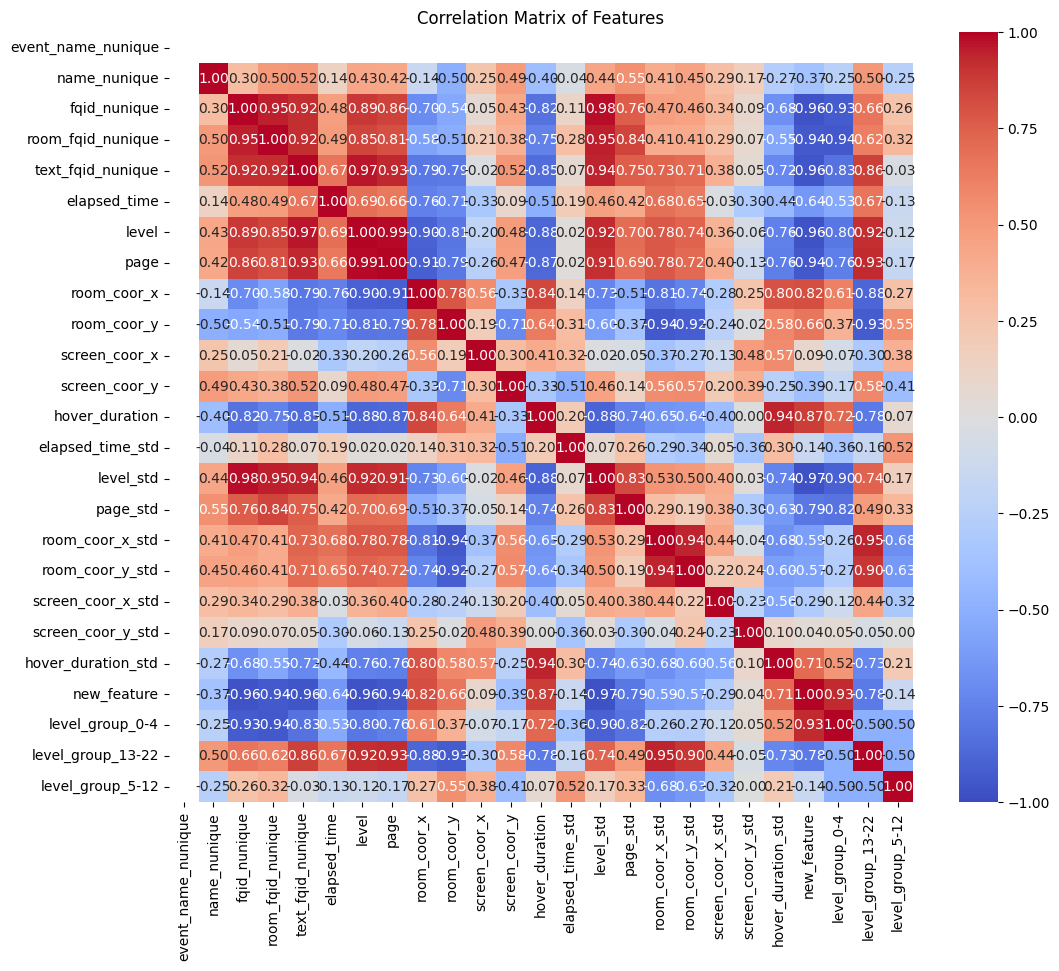

Explained Variance Ratio: [0.66234847 0.18509569 0.07492627 0.06012813]


In [109]:
# Perform PCA
df_encoded = test.copy()
# One-hot encode categorical features
df_encoded = pd.get_dummies(test, columns=['level_group'])

# Standardize numerical features
df_encoded[NUM] = scaler.fit_transform(df_encoded[NUM])

# Compute the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()

# Perform PCA
# Set the number of components you want
principal_components = pca.fit_transform(df_encoded[NUM])

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Print the explained variance ratio
print('Explained Variance Ratio:', pca.explained_variance_ratio_)

In [111]:
df_final['new_feature'] = test['new_feature']
df_final['level_group'] = test['level_group']
df_final = df_final.drop(columns=['level_group_0-4','level_group_5-12','level_group_13-22'])
df_final.head(5)

,new_feature,PC1,PC2,PC3,PC4,level_group
session_id,,,,,,
20090109393214576,0.893111,-1.745507,-1.598445,-0.602080,-0.748637,0-4
20090109393214576,0.603443,4.001491,-1.180185,1.263902,-0.596152,13-22
20090109393214576,0.726287,-1.590749,-0.656125,1.053408,1.314464,5-12
20090312143683264,0.899438,-2.438313,2.239880,0.689901,-0.942983,0-4
20090312143683264,0.605534,2.467710,1.596732,-0.175577,0.217770,13-22
